In [26]:
import xgboost as xgb
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import CategoricalEncoder
from sklearn.metrics import confusion_matrix

### Get the original data and transform it into xgb readable files - sparse array

In [27]:
#reads a weird json, and returns the bids dataframe and ads dataframe
def read_weird_json(path):
    bids = []
    ads = []

    with open(path) as f:
        for line in f:
            line_dict = json.loads(line.encode('utf-8'))
            if 'advertiser_id' in line_dict:
                if line_dict['rate_metric'] != 'CPC':
                    continue
                ads.append(line_dict)
            else:
                bids.append(line_dict)
    df_bids = pd.DataFrame.from_records(bids)
    df_ads = pd.DataFrame.from_records(ads)  
    
    return [df_bids, df_ads]

#Returns a list of dataframes. Only looks at ads. 
def read_many_jsons(paths): 
    dfs = []
    for path in paths: 
        dfs += [read_weird_json(path)[1]]
    return dfs

In [115]:
dfs = read_many_jsons(['./data/01-09-00001', './data/01-09-00003', './data/01-16-all'])

### DON'T RERUN

### DON'T RERUN

### DON'T RERUN

In [116]:
#Create one dataframe with the combined data. 
df = pd.concat(dfs)
df.fillna(0, inplace=True)

#### One hot encoding

In [117]:
#Turns a timestamp into which minute the time was at - used as a categorical feature.
def timestamp_to_min(timestamp, is_hour=True):
    if is_hour:
        return timestamp.split(':')[0][-2:]
    else: 
        return timestamp.split(':')[1]

#plots frequency of a feature's different classes, useful for exploratory analysis
def plot_freq(col_name, df):
    df_frequency = df.groupby(col_name).agg('count').sort_values('ad_type',ascending=False)
    plt.plot([i for i in range(len(df_frequency.values))], [np.log(i[2]) for i in df_frequency.values])
    plt.show()

#if a feature only has one unique value, it tells us nothing, so we drop it.
def remove_only_ones(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col, inplace=True,axis=1)

#just prints how many unique values are in each feature
def print_column_counts(df):    
    for i in df:
        print(i, df[i].nunique())

#We do some final cleaning, changing all non-numerical features into strings for later.
def preprocess(df):    
    for i in df:
        if i[-1] != 't' or i[-2] != 'n' or i[-3] != 'c':
            
            df[i] = df[i].astype('str')
    remove_only_ones(df)
    if 'site_id' in df.columns:
        df.drop('site_id',inplace=True,axis=1)
    
#given a categorical column, we apply our earlier strategy of one-hot-encoding with maximum thresh=200
def transform_column(df, col, thresh=10, return_labels=False):
    df_frequency = df[[col, 'c_cnt']].groupby(col).agg('count').sort_values('c_cnt',ascending=False)
    if df[col].nunique() > thresh:
        enc = CategoricalEncoder(categories=[sorted(df_frequency[0:thresh].index.values)],handle_unknown='ignore')
        labels = df_frequency[0:thresh].index.values
    else:
        enc = CategoricalEncoder(categories=[sorted(df_frequency.index.values)],handle_unknown='ignore')
        labels = df_frequency.index.values
    labels = [str(col) + str(i) for i in labels]
    if return_labels:
        return labels
    enc.fit(df[col].values.reshape(-1, 1))
    return enc.transform(df[col].values.reshape(-1,1)).toarray()

In [118]:
#final preprocessing
preprocess(df)

In [119]:
cutoff = int(np.floor(len(df) * 0.7))
# print "Total data: ", len(df), " Cutoff: ", cutoff
train_df = df.iloc[:cutoff, :]
test_df = df.iloc[cutoff:, :]
print train_df.shape
print test_df.shape

(140761, 80)
(60327, 80)


In [246]:
#this set contains our numerical column names
numerical_features = set(['c_cnt', 'c_flag_cnt', 'i_cnt', 'i_flag_cnt', 'r_cnt', 'vi_cnt', 'vi_flag_cnt', 'vv_cnt', 'vv_vvi_cnt'])

#we create a copy so that X will not include 'c_cnt'
df2 = df.copy()
print(df2.columns)
df2.drop('c_cnt',inplace=True,axis=1)
# df2.drop('f_cnt',inplace=True,axis=1)
X = np.hstack([transform_column(df, col) if col not in numerical_features else df[col].values.reshape(-1,1)
               for col in df2])
Y_true = df['c_cnt'].values[cutoff:]

Index([u'_host', u'ad_network_id', u'ad_type', u'adlog_count',
       u'advertiser_id', u'app_id', u'app_name', u'app_ver', u'bd',
       u'bid_requests', u'bid_responses', u'bundle_id', u'c_cnt',
       u'c_flag_cnt', u'c_timestamp', u'c_txn_fee', u'c_txn_rate',
       u'campaign_id', u'campaign_type', u'ck', u'cr', u'creative_id', u'dnt',
       u'exp_mode', u'flag', u'gaid', u'geo_area_code', u'geo_city_code',
       u'geo_city_name', u'geo_continent_code', u'geo_country_code2',
       u'geo_country_code3', u'geo_dma_code', u'geo_postal_code',
       u'geo_region_name', u'geo_timezone', u'i_cnt', u'i_flag_cnt',
       u'i_timestamp', u'idfa', u'ip_address', u'is_bot', u'is_fraud',
       u'keywords', u'lat', u'lla', u'llsdk', u'long', u'num_ads',
       u'pub_network_id', u'r_cnt', u'r_num_ads_requested',
       u'r_num_ads_returned', u'r_num_ads_third_party', u'r_timestamp',
       u'referer', u'sdk_version', u'session_id', u'token', u'txn_fee',
       u'txn_rate', u'ua', u'ua_devi

In [247]:
X_train = X[:cutoff, :]
X_test = X[cutoff:, :]
train_df = df.iloc[:cutoff, :]
test_df = df.iloc[cutoff:, :]

In [248]:
print(sum(df['c_cnt']))

65.0


### XGBoost

In [249]:
# X_train = np.delete(X_train, 70, axis=1)
# X_test = np.delete(X_train, 70, axis=1)

In [250]:
dtrain = xgb.DMatrix(X_train, label=train_df['c_cnt'])
dtest = xgb.DMatrix(X_test)

# dtrain.set_weight('f70', 0)

In [266]:
param = {'max_depth':10, 'eta':0.5, 'silent':0, 'eval_metric':'logloss', 'objective':'binary:logistic' }
num_round = 1
bst = xgb.train(param, dtrain, num_round, verbose_eval=200)

In [260]:
preds = bst.predict(dtest)

In [261]:
set(preds)

{0.26894701, 0.71678537}

In [262]:
print(sum(np.round(preds)))

13.0


In [263]:
print(sum(Y_true))

13.0


In [264]:
confusion_matrix(Y_true, np.round(preds))

array([[60314,     0],
       [    0,    13]])

## Playing around with XGBoost

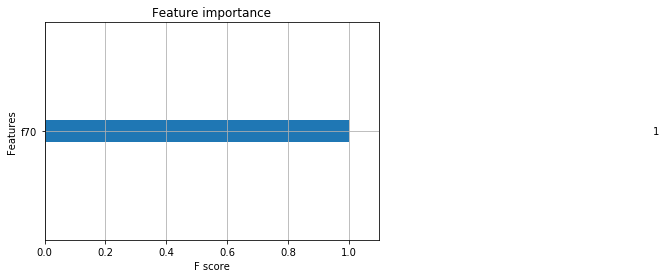

In [241]:
from xgboost import plot_importance

plot_importance(bst)